## Libraries and modules and methods

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from scipy.stats import pearsonr
from ipywidgets import interact, fixed, IntSlider

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from sklearn.linear_model import Ridge, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

### Import data

In [4]:
raw_data = pd.read_csv("./train.csv").drop('Id', axis=1)

## Data exploration

In [5]:
def categorical_to_int(df):
    return df.transform(lambda x: x.astype('category').cat.codes if x.dtype == 'O' else x)

data_train = categorical_to_int(raw_data)

corr_df = data_train.corr()

In [6]:
#corr_price = corr_df.sort_values(by=['SalePrice'], ascending=False).iloc[:, -1:]
#corr_price.iloc[np.where(np.logical_or(corr_price['SalePrice'] > 0.25, corr_price['SalePrice'] < -0.29))].index

### Plots

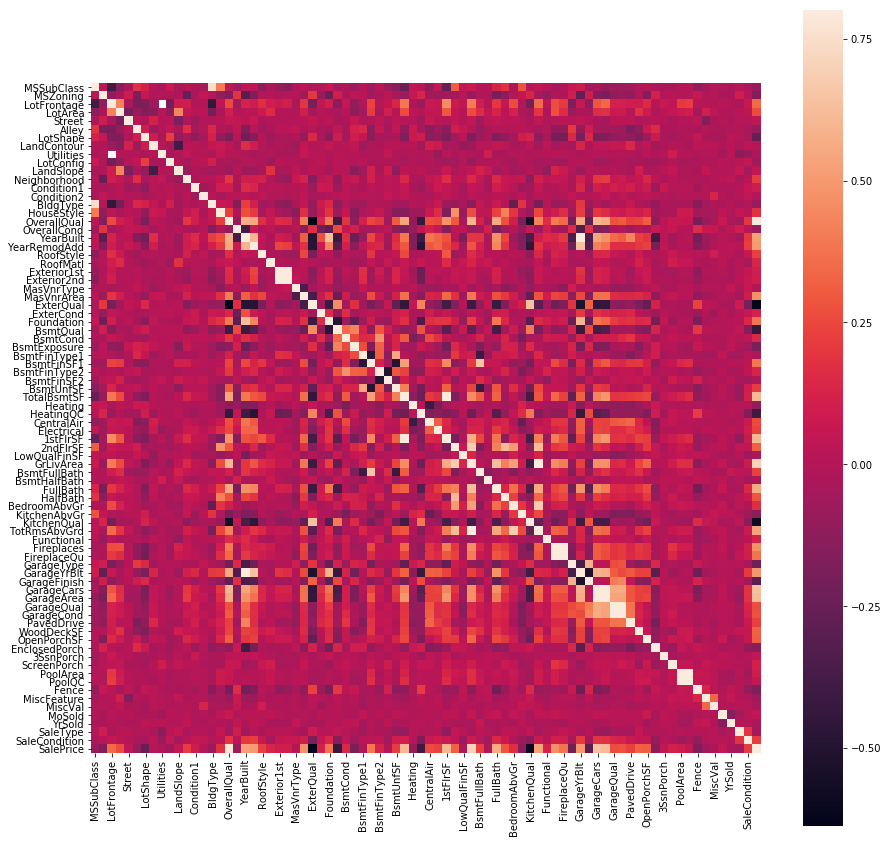

In [7]:
#sns.lmplot('a', 'b', data_train)

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_df, vmax=.8, square=True)

#sns.set()
#sns.pairplot(data_train, size = 2)
#plt.show()

### Feature Engineering

In [8]:
print(data_train.isnull().sum().sort_values(ascending=False).head())
print(np.isfinite(data_train).sum().sort_values().head())

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
SalePrice        0
Foundation       0
dtype: int64
LotFrontage    1201
GarageYrBlt    1379
MasVnrArea     1452
MSSubClass     1460
GarageType     1460
dtype: int64


In [9]:
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
data_train["LotFrontage"] = data_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Replace na in GarageYrBuilt with 0, since it means there's no garage at all
data_train['GarageYrBlt'] = data_train['GarageYrBlt'].fillna(0)

# Probabily no mansary for na values in MasVnrArea
data_train['MasVnrArea'] = data_train['MasVnrArea'].fillna(0)

In [10]:
X = data_train.drop('SalePrice', axis=1)
y = data_train['SalePrice']
feature_names = np.asarray(list(X))

# Models

### Lasso

In [ ]:
lasso = Lasso(max_iter=5000, random_state=0)

parameter = {'alpha': [0.01, 0.1, 1, 10, 100, 1000, 2000]}
regressor = GridSearchCV(lasso, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

In [ ]:
print('Train score: ', np.sqrt(-regressor.cv_results_['mean_train_score']))
print('Test score:  ', np.sqrt(-regressor.cv_results_['mean_test_score']))

lasso_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['alpha'])
lasso_scores.plot(title='Score as function of parameter alpha')
plt.xlabel("alpha")
plt.ylabel("smsle")

# Final Lasso

Text(0.5,1,'Lasso coefficients')

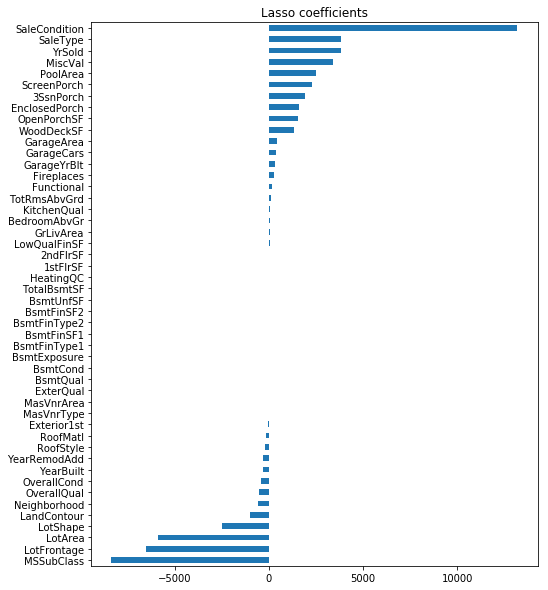

In [13]:
regressor = Lasso(alpha=1000, max_iter=5000, random_state=0).fit(X, y)

feature_lasso = feature_names[np.where(regressor.coef_ != 0)]
X = X[feature_lasso]

non_zero_coef = np.sort(regressor.coef_[np.where(regressor.coef_ != 0)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
pd.Series(non_zero_coef, feature_lasso).plot(kind = "barh")
plt.title("Lasso coefficients")

### Ridge

Train score:  [ 0.14653176  0.14646014  0.14648151  0.14657734  0.14673317]
Test score:   [ 0.15927455  0.15914417  0.15913419  0.15921791  0.1593752 ]


Text(0,0.5,'smsle')

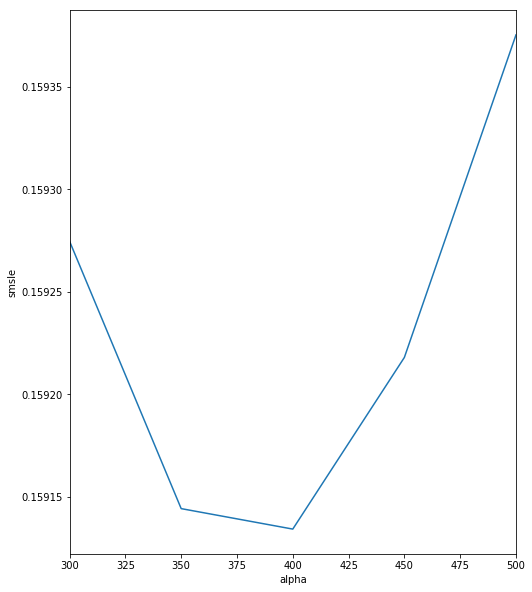

In [14]:
rigde = Ridge(random_state=0)
parameter = {'alpha': [300,  350, 400, 450, 500]}
regressor = GridSearchCV(rigde, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

print('Train score: ', np.sqrt(-regressor.cv_results_['mean_train_score']))
print('Test score:  ', np.sqrt(-regressor.cv_results_['mean_test_score']))

ridge_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['alpha'])
ridge_scores.plot()
plt.xlabel("alpha")
plt.ylabel("smsle")

### ElasticNet

Train score:  [ 0.14645749  0.14645778  0.14645858  0.1464599   0.14646173  0.14646405
  0.14646685  0.14647014  0.1464739   0.14647812]
Test score:   [ 0.15913148  0.15912895  0.15912708  0.15912587  0.1591253   0.15912537
  0.15912605  0.15912734  0.15912922  0.15913169]


Text(0,0.5,'smsle')

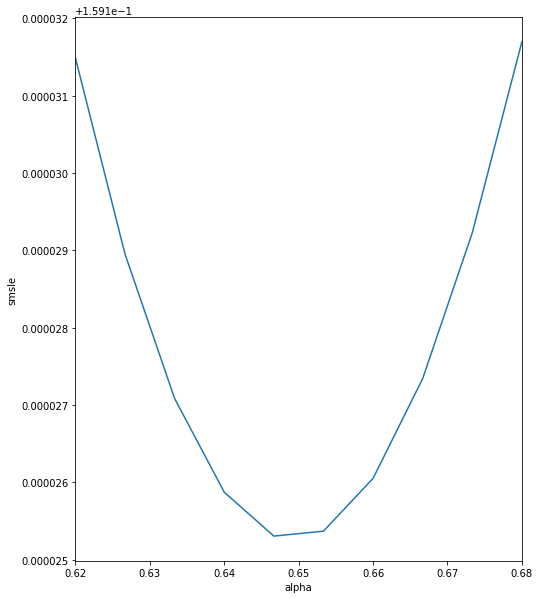

In [15]:
el_net = ElasticNet(random_state=0)

parameter = {'alpha': np.linspace(0.62, 0.68, 10)}
regressor = GridSearchCV(el_net, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

print('Train score: ', np.sqrt(-regressor.cv_results_['mean_train_score']))
print('Test score:  ', np.sqrt(-regressor.cv_results_['mean_test_score']))

el_net_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['alpha'])
el_net_scores.plot()
plt.xlabel("alpha")
plt.ylabel("smsle")

Train score:  [ 0.14650756  0.14649396  0.14648239  0.14647292  0.14646563  0.1464606
  0.14645792  0.14645769  0.14645998  0.14646491]
Test score:   [ 0.15915388  0.15914292  0.1591345   0.15912872  0.1591257   0.15912555
  0.15912839  0.15913435  0.15914357  0.1591562 ]


Text(0,0.5,'smsle')

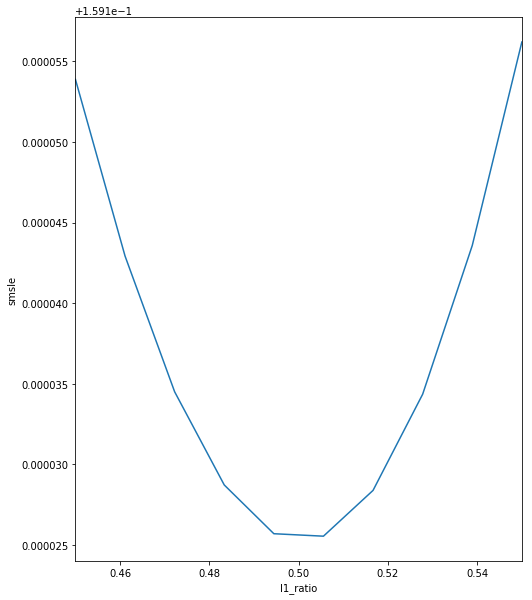

In [16]:
el_net = ElasticNet(alpha=0.65, random_state=0)

parameter = {'l1_ratio': np.linspace(0.45, 0.55, 10)}
regressor = GridSearchCV(el_net, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

print('Train score: ', np.sqrt(-regressor.cv_results_['mean_train_score']))
print('Test score:  ', np.sqrt(-regressor.cv_results_['mean_test_score']))

el_net_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['l1_ratio'])
el_net_scores.plot()
plt.xlabel("l1_ratio")
plt.ylabel("smsle")

### GradientBoostingRegressor

Train score:  [ 0.08646771  0.08478609  0.0835672   0.08176834  0.08036187  0.07970508
  0.07890085  0.07736135  0.07624788  0.07558001]
Test score:   [ 0.1308573   0.13435176  0.13339198  0.1309098   0.13344706  0.13135622
  0.13257072  0.13072795  0.13207816  0.13502736]


Text(0,0.5,'smsle')

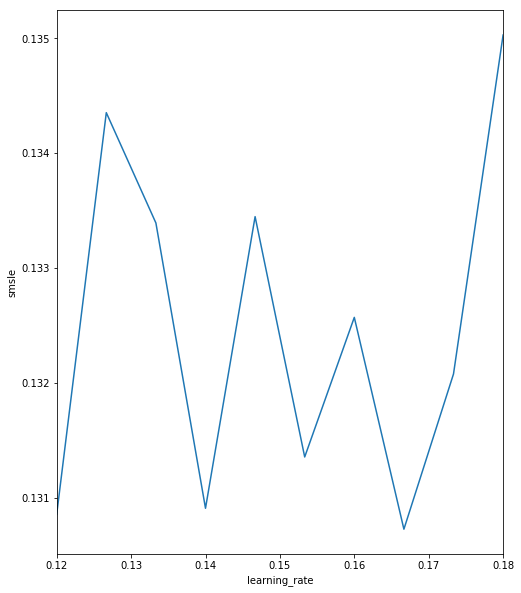

In [17]:
gbr = GradientBoostingRegressor(verbose=0, random_state=0)

parameter = {'learning_rate': np.linspace(0.12, 0.18, 10)}
regressor = GridSearchCV(gbr, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

print('Train score: ', np.sqrt(-regressor.cv_results_['mean_train_score']))
print('Test score:  ', np.sqrt(-regressor.cv_results_['mean_test_score']))

gbr_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['learning_rate'])
gbr_scores.plot()
plt.xlabel("learning_rate")
plt.ylabel("smsle")

Train score:  [ 0.07503249  0.07457335  0.07405268  0.0737542   0.07313303  0.07275183
  0.0721694   0.07185905  0.07133495  0.07097707  0.07054576  0.07016569
  0.06977265  0.06934274  0.06886592  0.0685453   0.06810821  0.06759888
  0.06723541  0.0669015 ]
Test score:   [ 0.13150754  0.13152863  0.13133366  0.13122891  0.13131175  0.13128231
  0.13124269  0.13124023  0.13117057  0.13116208  0.13109949  0.1311155
  0.13113591  0.13109642  0.13113499  0.13108297  0.13118916  0.13117324
  0.13113755  0.13113421]


Text(0,0.5,'smsle')

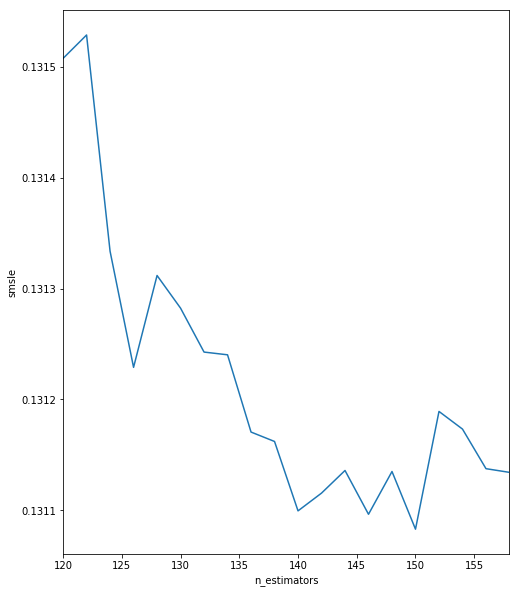

In [63]:
gbr = GradientBoostingRegressor(learning_rate=0.15, verbose=0, random_state=0)

parameter = {'n_estimators': np.arange(120, 160, 2)}
regressor = GridSearchCV(gbr, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

print('Train score: ', np.sqrt(-regressor.cv_results_['mean_train_score']))
print('Test score:  ', np.sqrt(-regressor.cv_results_['mean_test_score']))

gbr_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['n_estimators'])
gbr_scores.plot()
plt.xlabel("n_estimators")
plt.ylabel("smsle")

Train score:  [ 0.07255483  0.09662045]
Test score:   [ 0.12853996  0.13423834]


Text(0,0.5,'smsle')

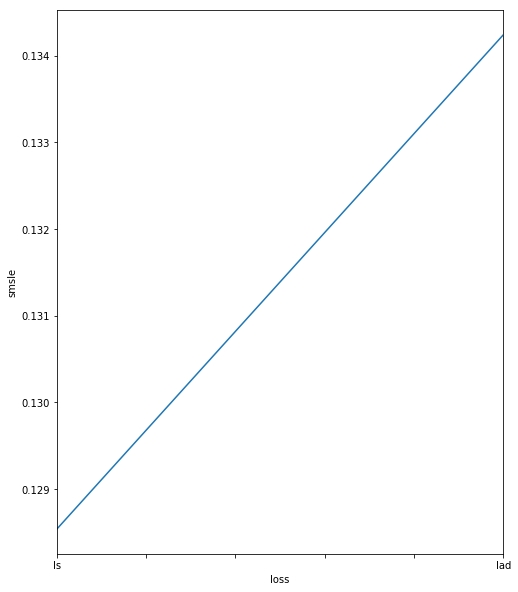

In [64]:
gbr = GradientBoostingRegressor(learning_rate=0.15, n_estimators=150, verbose=0, random_state=0)

parameter = {'loss': ['ls', 'lad']}
regressor = GridSearchCV(gbr, parameter, cv=10, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

print('Train score: ', np.sqrt(-regressor.cv_results_['mean_train_score']))
print('Test score:  ', np.sqrt(-regressor.cv_results_['mean_test_score']))

gbr_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['loss'])
gbr_scores.plot()
plt.xlabel("loss")
plt.ylabel("smsle")

### Random Forest

Train score:  [ 0.07503249  0.07457335  0.07405268  0.0737542   0.07313303  0.07275183
  0.0721694   0.07185905  0.07133495  0.07097707  0.07054576  0.07016569
  0.06977265  0.06934274  0.06886592]
Test score:   [ 0.13150754  0.13152863  0.13133366  0.13122891  0.13131175  0.13128231
  0.13124269  0.13124023  0.13117057  0.13116208  0.13109949  0.1311155
  0.13113591  0.13109642  0.13113499]


Text(0,0.5,'smsle')

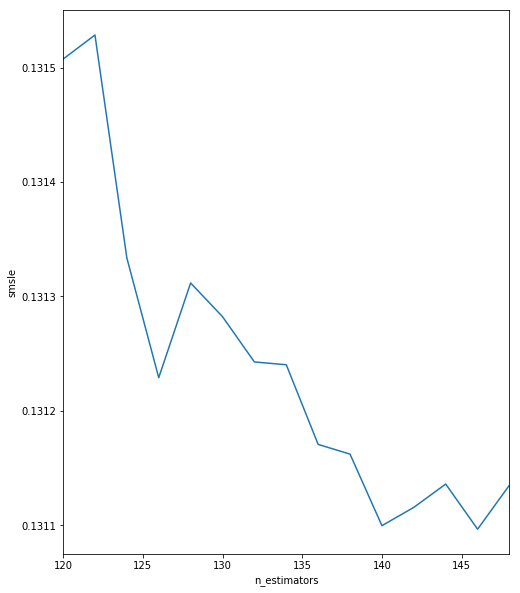

In [66]:
rfr = RandomForestRegressor(random_state=0)

parameter = {'n_estimators': np.arange(120, 150, 2)}
regressor = GridSearchCV(gbr, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

print('Train score: ', np.sqrt(-regressor.cv_results_['mean_train_score']))
print('Test score:  ', np.sqrt(-regressor.cv_results_['mean_test_score']))

gbr_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['n_estimators'])
gbr_scores.plot()
plt.xlabel("n_estimators")
plt.ylabel("smsle")

Train score:  [ 0.09507242  0.0685453   0.04248258]
Test score:   [ 0.13214975  0.13108297  0.13288053]


Text(0,0.5,'smsle')

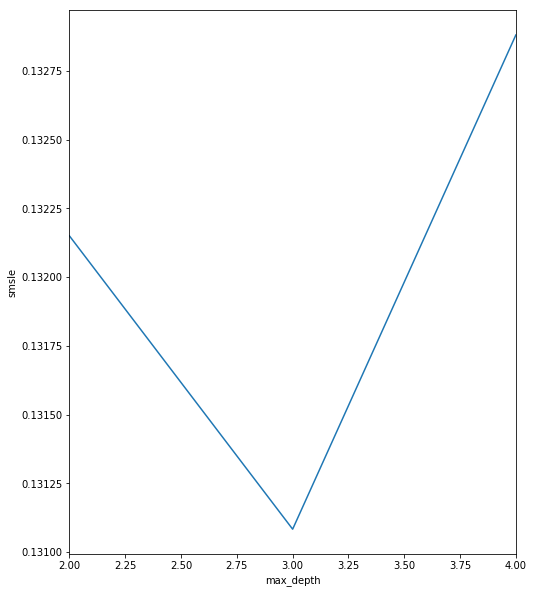

In [67]:
rfr = RandomForestRegressor(n_estimators=140, random_state=0)

parameter = {'max_depth': [2, 3, 4]}
regressor = GridSearchCV(gbr, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

print('Train score: ', np.sqrt(-regressor.cv_results_['mean_train_score']))
print('Test score:  ', np.sqrt(-regressor.cv_results_['mean_test_score']))

gbr_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['max_depth'])
gbr_scores.plot()
plt.xlabel("max_depth")
plt.ylabel("smsle")

Train score:  [ 0.0685453   0.07948459  0.08263457]
Test score:   [ 0.13108297  0.13212506  0.13891896]


Text(0,0.5,'smsle')

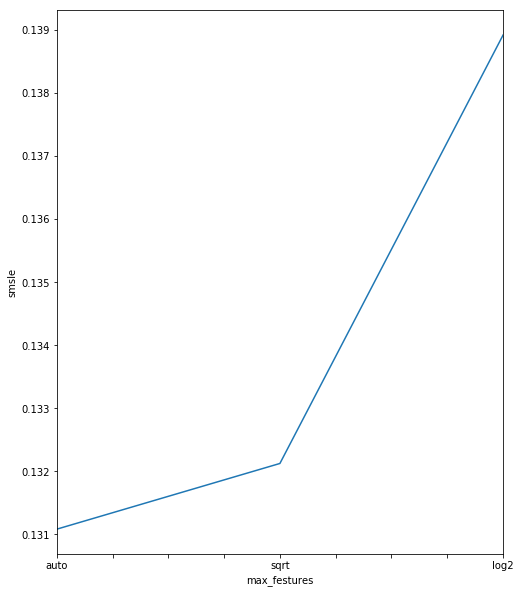

In [68]:
rfr = RandomForestRegressor(n_estimators=140, max_depth=3, random_state=0)

parameter = {'max_features': ['auto', 'sqrt', 'log2']}
regressor = GridSearchCV(gbr, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

print('Train score: ', np.sqrt(-regressor.cv_results_['mean_train_score']))
print('Test score:  ', np.sqrt(-regressor.cv_results_['mean_test_score']))

gbr_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['max_features'])
gbr_scores.plot()
plt.xlabel("max_festures")
plt.ylabel("smsle")

# Winners!!!

### Read Data

In [19]:
data_test = categorical_to_int(pd.read_csv('test.csv').drop('Id', axis=1))
corr_df = data_test[feature_lasso].corr()

### Plot

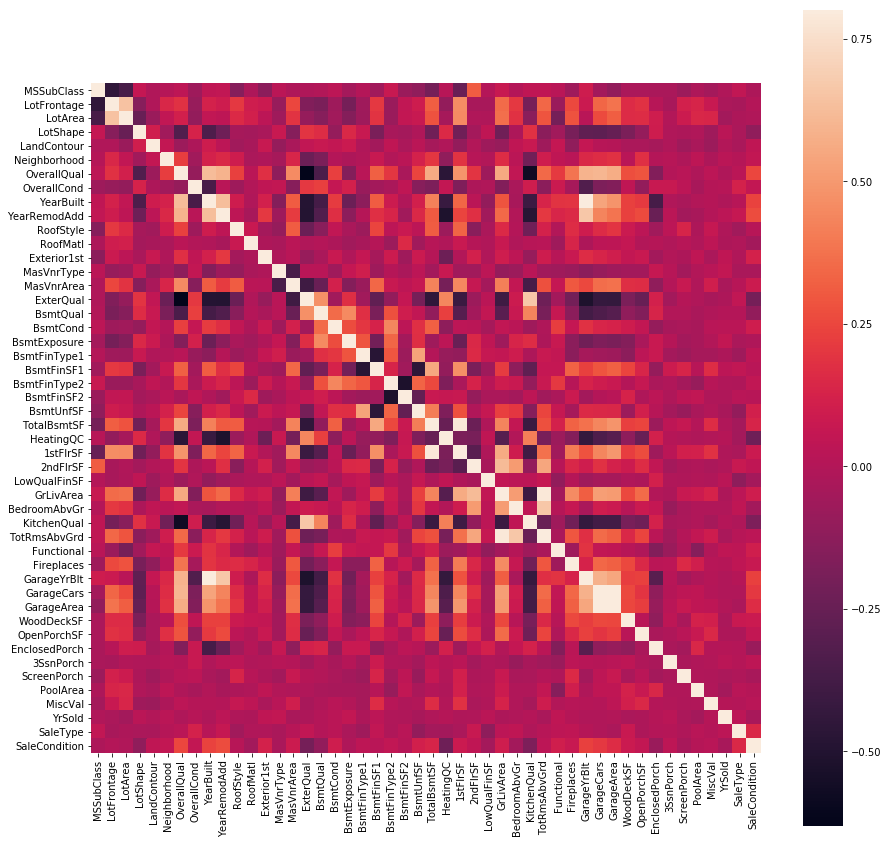

In [20]:
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_df, vmax=.8, square=True)

#sns.set()
#sns.pairplot(data_train, size = 2)
#plt.show()

### Feature Engineering

In [26]:
print(data_train.isnull().sum().sort_values(ascending=False).head())
print(np.isfinite(data_train).sum().sort_values().head())

SalePrice        0
SaleCondition    0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
dtype: int64
MSSubClass     1460
GarageType     1460
FireplaceQu    1460
Fireplaces     1460
Functional     1460
dtype: int64


In [29]:
X_test = data_test[feature_lasso]

(1460, 48)

# Final Results :o

In [24]:
gbr = GradientBoostingRegressor(learning_rate=0.15, n_estimators=150, loss='ls', verbose=0, random_state=0)
gbr.fit(X, y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
rfr = RandomForestRegressor(n_estimators=140, max_depth=3, random_state=0)
rfr.fit(X, y)

In [ ]:
gbr.predict(X_test).to_csv('GradientBoosting.csv')
rfr.predict(X_test).to_csv('RandomForest.csv')